# Multivariate Multifractals To Modelize Spatial Segregation

In [1]:
import pandas as pd
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib as mpl

## Functions

In [2]:
def multivariate_lognormal_cascade(n, sigma1=1, sigma2=1, corr=0):
    mu1 = -1/2 * sigma1**2
    mu2 = -1/2 * sigma2**2

    PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),  np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), 4))

    P = PQ[:,0].reshape(2,2)
    Q = PQ[:,1].reshape(2,2)
    for i in range(n):
        PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), P.shape[0]**2 * 4))
        P = np.kron(P, np.ones((2,2)))
        P = P * PQ[:,0].reshape(P.shape)
        Q = np.kron(Q, np.ones((2,2)))
        Q = Q * PQ[:,1].reshape(P.shape)

    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return(np.stack([P,Q], axis=-1))

In [42]:
lnc = multivariate_lognormal_cascade(6, sigma1=.4, sigma2=.4, corr=.0)
ratio = .2 * lnc[:,:,0] / (.2 * lnc[:,:,0] + .8 * lnc[:,:,1]) * 100

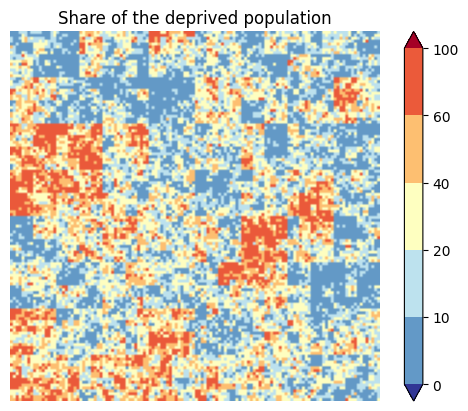

In [44]:
cmap = mpl.cm.RdYlBu_r
bounds = [0, 10, 20, 40, 60, 100]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
ax.set_axis_off();
ax.set_title('Share of the deprived population');
ax.imshow(cmap(norm(ratio)))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax);